In [8]:
from google.colab import files
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [39]:
cd '/gdrive/My Drive/Colab Notebooks/sumit_gene/'

/gdrive/My Drive/Colab Notebooks/sumit_gene


In [40]:
ls

gbbct103.seq           promoters_cleaned.csv     promoter_with_spectogram.csv
gene_sequencing.ipynb  promoters_cleaned.gsheet  runs/
H3.csv                 promoters.csv             test.png
logs/                  promoter_spect/


In [294]:
import numpy as np
import pandas as pd
import os
import copy
from IPython.display import Image
from datetime import datetime

from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import ShuffleSplit

from torchvision import datasets, transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset
writer = SummaryWriter()

from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent


## Functions

In [254]:
def show_img(img, class_name):
    if torch.is_tensor(img):
        img=to_pil_image(img)
    print("class :",class_name)
    plt.imshow(img)

In [255]:
def show_images(images, labels, preds,class_names):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}',fontsize = 40)
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col,fontsize = 40)
    plt.tight_layout()
    plt.show()

In [305]:
def show_preds(model,loader,image_fun,loss_fn,class_names):
    model.eval() 
    print("test set evaluation")

    with torch.no_grad():
        accuracy = 0
        pred = []
        train = []
        for test_step, (images, labels) in enumerate(loader):

          x_train = change_device(images)
          y_train = change_device(labels)
          y_pred = model(x_train)

          loss = loss_fn(y_pred,y_train)
          preds = torch.round(torch.sigmoid(y_pred))
          accuracy += sum(( preds.flatten().cpu() == labels.cpu()).numpy())
          pred+=preds.flatten().cpu()
          train+=labels.flatten().cpu()
          
        accuracy = accuracy/len(loader.dataset)
        print(f' Accuracy: {accuracy:.4f}')
        image_fun(images, labels, preds.cpu(),class_names)
      
    return pred,train

In [257]:
def gene_tag(gene):
  gene_seq = []
  for i in range(len(gene)):
    if (gene[i]=="t"):
      gene_seq.append(0)
    elif (gene[i]=="g"):
      gene_seq.append(3)
    elif (gene[i]=="c"):
      gene_seq.append(1)
    elif (gene[i]=="a"):
      gene_seq.append(2)
  return gene_seq

In [258]:
ham = signal.get_window('hamming', 30)
def get_spectogram(gene_seq,path):
  f, t, Sxx = signal.spectrogram(np.array(gene_seq), fs=1, window = ham, mode = 'magnitude')
  plt.pcolormesh(t, f, Sxx, shading='gouraud')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel("Nucleotide Positions")
  plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
  plt.axis('tight')
  plt.axis('off')
  plt.savefig(path+'.png', dpi=300, frameon='false')

In [259]:
def change_device(input):
  if torch.cuda.is_available():
    return input.cuda()
  else:
    return input

In [260]:
def cudaalloc():
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'total    : {info.total}')
  print(f'free     : {info.free}')
  print(f'used     : {info.used}')

In [261]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [292]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    with torch.no_grad():
        pred = torch.round(torch.sigmoid(output))
        #(pred.flatten().cpu() == target.flatten().cpu()).sum().float()
        metric_b = sum(( pred.flatten().cpu() == target.cpu()).numpy())
        
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [263]:
def loss_func(pred, target):
    pred = pred.flatten()
    
    bce = F.binary_cross_entropy_with_logits(pred.float(), target.float(),  reduction='sum')
    loss = bce

    return loss

In [264]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    count=0;
    for xb, yb in tqdm(dataset_dl):
        xb=change_device(xb)
        yb=change_device(yb)
        count+=1;
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if (count%10==0):
          print("Batch",count,loss_b)
          
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)
    
    metric=running_metric/float(len_data)
    
    return loss, metric

In [265]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [266]:

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        writer.add_scalar("Loss/train", train_loss, epoch)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        writer.add_scalar("Loss/val", val_loss, epoch)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        print(train_metric)    
        print("train loss: %.6f, accuracy: %.2f" %(train_loss,train_metric))
        print("val loss: %.6f, accuracu: %.2f" %(val_loss,val_metric))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

#Getting the spectograms

In [5]:
promoter = pd.read_csv('promoters_cleaned.csv')
promoter = promoter.drop('Unnamed: 0', 1)
promoter.head()

,Promoter/Non_promoter,Type,Gene sequence
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...


In [6]:
root = 'promoter_spect/'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # Remove the CWD from sys.path while we load stuff.


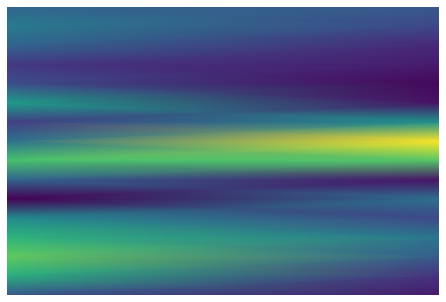

In [17]:
path = []
for i in range(len(promoter)):
  gene = promoter["Gene sequence"][i]
  gene_seq = gene_tag(gene)
  gene_name = promoter["Type"][i]
  type_gene = ''
  if (promoter["Promoter/Non_promoter"][i]=='+'):
    type_gene = 'promoter'
  elif (promoter["Promoter/Non_promoter"][i]=='-'):
    type_gene = 'inhibitor'
  image_path = os.path.join(root,type_gene,gene_name)
  get_spectogram(gene_seq,image_path)
  path.append(image_path+'.png')


In [18]:
promoter['spect_image'] = path

In [19]:
promoter.to_csv('promoter_with_spectogram.csv')

# Deep learning classification

## Data Loader

In [267]:
promoter = pd.read_csv('promoter_with_spectogram.csv')
promoter = promoter.drop('Unnamed: 0', 1)
promoter

,Promoter/Non_promoter,Type,Gene sequence,spect_image
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,promoter_spect/promoter/S10.png
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,promoter_spect/promoter/AMPC.png
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,promoter_spect/promoter/AROH.png
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,promoter_spect/promoter/DEOP2.png
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,promoter_spect/promoter/LEU1_TRNA.png
...,...,...,...,...
101,-,799,cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...,promoter_spect/inhibitor/799.png
102,-,987,gtattctcaacaagattaaccgacagattcaatctcgtggatggac...,promoter_spect/inhibitor/987.png
103,-,1226,cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...,promoter_spect/inhibitor/1226.png
104,-,794,ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...,promoter_spect/inhibitor/794.png


In [268]:
class_name = []
for i in range(len(promoter)):
  if (promoter['Promoter/Non_promoter'][i]=='+'):
    class_name.append(1)
  elif (promoter['Promoter/Non_promoter'][i]=='-'):
    class_name.append(0)

promoter['class_name'] = class_name

In [269]:
promoter.head()

,Promoter/Non_promoter,Type,Gene sequence,spect_image,class_name
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,promoter_spect/promoter/S10.png,1
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,promoter_spect/promoter/AMPC.png,1
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,promoter_spect/promoter/AROH.png,1
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,promoter_spect/promoter/DEOP2.png,1
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,promoter_spect/promoter/LEU1_TRNA.png,1


In [270]:
class specto_dataset(Dataset):
    def __init__(self, dataframe, transform=None):      

        self.SpecPath = dataframe['spect_image'].values
        self.ClassName = dataframe['class_name'].values

        self.transform = transform
    
    def __len__(self):
        return len(self.SpecPath)
      
    def __getitem__(self, idx):
        path2img = self.SpecPath[idx]
        class_name = self.ClassName[idx]
        image = Image.open(path2img).convert('RGB')

        image= np.array(image)    

        if self.transform:
            image = self.transform(image)       
          #he to_tensor function normalizes the values by diving them to 255. As such, we scaled back the mask values to the range of [0, 1] by multiplying it by 255.             
        return image, class_name

In [271]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

In [272]:
spec_ds1=specto_dataset(promoter,transform)
spec_ds2=specto_dataset(promoter,transform)
print(len(spec_ds1))
print(len(spec_ds1))

106
106


In [273]:
img,class_name= spec_ds1[2]
print(img.shape, img.type(),torch.max(img),class_name)

torch.Size([3, 224, 224]) torch.FloatTensor tensor(0.9647) 1


In [274]:
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(spec_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

84
----------
22


In [275]:

'''
we passed the train_index and val_index to the Subset class from
the torch.utils.data package to create the training and validation datasets,
respectively
'''
train_ds=Subset(spec_ds1,train_index)
print(len(train_ds))

val_ds=Subset(spec_ds2,val_index)
print(len(val_ds))

84
22


class : 1


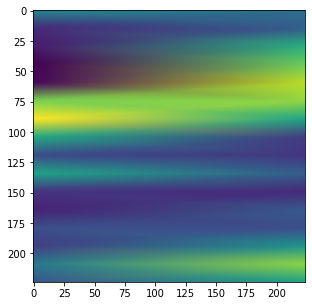

In [276]:
plt.figure(figsize=(5,5))
for img,class_name in train_ds:
    show_img(img, class_name)
    break

class : 0


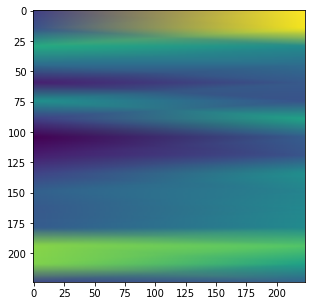

In [277]:
plt.figure(figsize=(5,5))
for img,class_name in val_ds:
    show_img(img, class_name) 
    break

In [278]:
batch_size = 4
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [279]:
for img_b, class_name in train_dl:
    print(img_b.shape,class_name)
    break

torch.Size([4, 3, 224, 224]) tensor([1, 1, 0, 0])


In [280]:
for img_b, class_name in val_dl:
    print(img_b.shape,class_name)
    break

torch.Size([4, 3, 224, 224]) tensor([0, 1, 0, 1])


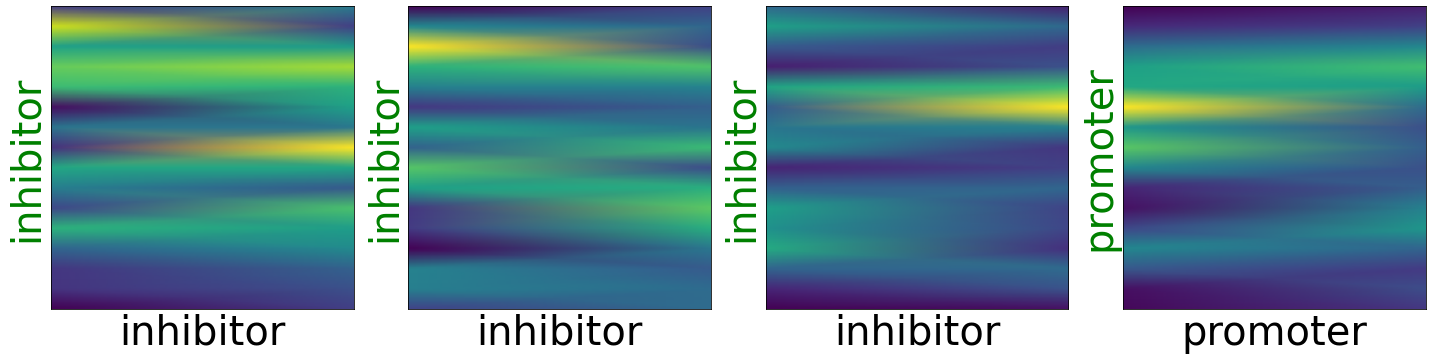

In [282]:
class_names = {}
class_names[1] = 'promoter'
class_names[0] = 'inhibitor'
show_images(images,labels,labels,class_names)

## Model Implementation

In [283]:
densenet121 = torchvision.models.densenet121(pretrained=False)

In [284]:
class DenseNet(nn.Module):
    def __init__(self, model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.averagepool = nn.AdaptiveAvgPool2d(1)
        
        # get the classifier of the vgg19
        self.classifier = torch.nn.Linear(in_features=1024, out_features=1)
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        if x.requires_grad:
          h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [285]:
model = change_device(DenseNet(densenet121))

In [286]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 7,979,881 trainable parameters and total memory usage is 91.32249069213867 mb


In [287]:
opt = optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [288]:
root = 'promoter_spect/'

In [293]:
path2models= root + "models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+ "EF_" + datetime.now().strftime('%Y-%m-%d_%H:%M:%S_') + "weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/49, current lr=0.0003


Batch 10 3.0707786083221436
Batch 20 2.4604077339172363




Copied best model weights!
0.5952380952380952
train loss: 0.716336, accuracy: 0.60
val loss: 0.892610, accuracu: 0.50
----------
Epoch 1/49, current lr=0.0003


Batch 10 3.8723177909851074
Batch 20 2.2439796924591064




0.6785714285714286
train loss: 0.603046, accuracy: 0.68
val loss: 1.261820, accuracu: 0.41
----------
Epoch 2/49, current lr=0.0003


Batch 10 2.153911590576172
Batch 20 2.4901928901672363




Copied best model weights!
0.7380952380952381
train loss: 0.528841, accuracy: 0.74
val loss: 0.560537, accuracu: 0.64
----------
Epoch 3/49, current lr=0.0003


Batch 10 1.075742244720459
Batch 20 1.4045307636260986




0.8214285714285714
train loss: 0.483432, accuracy: 0.82
val loss: 0.802839, accuracu: 0.64
----------
Epoch 4/49, current lr=0.0003


Batch 10 1.2558228969573975
Batch 20 1.0765712261199951




0.8095238095238095
train loss: 0.410533, accuracy: 0.81
val loss: 0.781814, accuracu: 0.59
----------
Epoch 5/49, current lr=0.0003


Batch 10 0.6436285972595215
Batch 20 0.6951820254325867




0.9047619047619048
train loss: 0.273211, accuracy: 0.90
val loss: 0.597848, accuracu: 0.68
----------
Epoch 6/49, current lr=0.0003


Batch 10 0.9214436411857605
Batch 20 0.39906543493270874




0.7857142857142857
train loss: 0.414791, accuracy: 0.79
val loss: 1.274255, accuracu: 0.50
----------
Epoch 7/49, current lr=0.0003


Batch 10 1.9733984470367432
Batch 20 2.3441662788391113




0.8690476190476191
train loss: 0.331497, accuracy: 0.87
val loss: 0.687102, accuracu: 0.68
----------
Epoch 8/49, current lr=0.0003


Batch 10 1.5668343305587769
Batch 20 5.104568004608154




0.8809523809523809
train loss: 0.259880, accuracy: 0.88
val loss: 1.091630, accuracu: 0.59
----------
Epoch 9/49, current lr=0.0003


Batch 10 0.33538541197776794
Batch 20 1.065394639968872




0.8928571428571429
train loss: 0.262936, accuracy: 0.89
val loss: 1.062194, accuracu: 0.59
----------
Epoch 10/49, current lr=0.0003


Batch 10 0.22283640503883362
Batch 20 0.5165838599205017




0.8809523809523809
train loss: 0.310345, accuracy: 0.88
val loss: 0.661044, accuracu: 0.59
----------
Epoch 11/49, current lr=0.0003


Batch 10 0.3325144350528717
Batch 20 5.612738609313965




0.8690476190476191
train loss: 0.298289, accuracy: 0.87
val loss: 0.610067, accuracu: 0.68
----------
Epoch 12/49, current lr=0.0003


Batch 10 0.16960233449935913
Batch 20 1.0288336277008057




0.8928571428571429
train loss: 0.289671, accuracy: 0.89
val loss: 0.560891, accuracu: 0.68
----------
Epoch 13/49, current lr=0.0003


Batch 10 0.14797885715961456
Batch 20 0.8307071924209595




0.8214285714285714
train loss: 0.333371, accuracy: 0.82
val loss: 0.734463, accuracu: 0.68
----------
Epoch 14/49, current lr=0.0003


Batch 10 0.09092290699481964
Batch 20 0.683014988899231




0.8214285714285714
train loss: 0.347718, accuracy: 0.82
val loss: 0.795758, accuracu: 0.68
----------
Epoch 15/49, current lr=0.0003


Batch 10 0.5838832855224609
Batch 20 0.9264271855354309




Copied best model weights!
0.8333333333333334
train loss: 0.294575, accuracy: 0.83
val loss: 0.366586, accuracu: 0.82
----------
Epoch 16/49, current lr=0.0003


Batch 10 0.3777972459793091
Batch 20 0.05711118504405022




0.8214285714285714
train loss: 0.292552, accuracy: 0.82
val loss: 0.431285, accuracu: 0.82
----------
Epoch 17/49, current lr=0.0003


Batch 10 0.03372162580490112
Batch 20 0.18988050520420074




0.8571428571428571
train loss: 0.259620, accuracy: 0.86
val loss: 0.473760, accuracu: 0.82
----------
Epoch 18/49, current lr=0.0003


Batch 10 0.13248640298843384
Batch 20 0.10316960513591766




0.8928571428571429
train loss: 0.241482, accuracy: 0.89
val loss: 0.449524, accuracu: 0.77
----------
Epoch 19/49, current lr=0.0003


Batch 10 0.06495346873998642
Batch 20 0.03165242820978165




0.9642857142857143
train loss: 0.100287, accuracy: 0.96
val loss: 0.569924, accuracu: 0.73
----------
Epoch 20/49, current lr=0.0003


Batch 10 0.38707393407821655
Batch 20 0.3605843484401703




0.9404761904761905
train loss: 0.147550, accuracy: 0.94
val loss: 0.935780, accuracu: 0.64
----------
Epoch 21/49, current lr=0.0003


Batch 10 1.927866816520691
Batch 20 0.6262314915657043




0.9642857142857143
train loss: 0.111767, accuracy: 0.96
val loss: 1.455752, accuracu: 0.59
----------
Epoch 22/49, current lr=0.0003


Batch 10 0.16101057827472687
Batch 20 5.138154983520508




0.9166666666666666
train loss: 0.260983, accuracy: 0.92
val loss: 0.817995, accuracu: 0.73
----------
Epoch 23/49, current lr=0.0003


Batch 10 0.8529689908027649
Batch 20 0.35659924149513245




0.9166666666666666
train loss: 0.209846, accuracy: 0.92
val loss: 0.517009, accuracu: 0.73
----------
Epoch 24/49, current lr=0.0003


Batch 10 0.7446819543838501
Batch 20 0.5092446208000183




Copied best model weights!
0.8928571428571429
train loss: 0.250215, accuracy: 0.89
val loss: 0.262824, accuracu: 0.82
----------
Epoch 25/49, current lr=0.0003


Batch 10 0.26668450236320496
Batch 20 0.723896324634552




0.8809523809523809
train loss: 0.303086, accuracy: 0.88
val loss: 0.755712, accuracu: 0.64
----------
Epoch 26/49, current lr=0.0003


Batch 10 0.417783260345459
Batch 20 1.3359116315841675




0.9523809523809523
train loss: 0.140193, accuracy: 0.95
val loss: 0.477831, accuracu: 0.73
----------
Epoch 27/49, current lr=0.0003


Batch 10 4.37932825088501
Batch 20 0.6055103540420532




0.9642857142857143
train loss: 0.142388, accuracy: 0.96
val loss: 0.582604, accuracu: 0.77
----------
Epoch 28/49, current lr=0.0003


Batch 10 3.1983206272125244
Batch 20 0.22313639521598816




0.8690476190476191
train loss: 0.282231, accuracy: 0.87
val loss: 0.785834, accuracu: 0.68
----------
Epoch 29/49, current lr=0.0003


Batch 10 0.6520932912826538
Batch 20 3.5847368240356445




0.8690476190476191
train loss: 0.267845, accuracy: 0.87
val loss: 0.546144, accuracu: 0.68
----------
Epoch 30/49, current lr=0.0003


Batch 10 0.5123717188835144
Batch 20 0.32038769125938416




0.9642857142857143
train loss: 0.126350, accuracy: 0.96
val loss: 0.747021, accuracu: 0.77
----------
Epoch 31/49, current lr=0.0003


Batch 10 0.6552913188934326
Batch 20 0.22916293144226074




0.9523809523809523
train loss: 0.181744, accuracy: 0.95
val loss: 0.588856, accuracu: 0.73
----------
Epoch 32/49, current lr=0.0003


Batch 10 0.004892820026725531
Batch 20 0.1847127377986908




0.9404761904761905
train loss: 0.145252, accuracy: 0.94
val loss: 0.820901, accuracu: 0.77
----------
Epoch 33/49, current lr=0.0003


Batch 10 0.010861556977033615
Batch 20 3.396651029586792




0.8809523809523809
train loss: 0.221003, accuracy: 0.88
val loss: 0.479431, accuracu: 0.77
----------
Epoch 34/49, current lr=0.0003


Batch 10 0.05241599306464195
Batch 20 0.5640649795532227




0.9285714285714286
train loss: 0.147399, accuracy: 0.93
val loss: 0.395045, accuracu: 0.82
----------
Epoch 35/49, current lr=0.0003


Batch 10 0.47476595640182495
Batch 20 0.22474445402622223




0.9642857142857143
train loss: 0.159648, accuracy: 0.96
val loss: 0.666972, accuracu: 0.68
----------
Epoch 36/49, current lr=0.0003


Batch 10 0.23016342520713806
Batch 20 0.057329703122377396




0.9285714285714286
train loss: 0.147693, accuracy: 0.93
val loss: 0.664412, accuracu: 0.68
----------
Epoch 37/49, current lr=0.0003


Batch 10 0.1716660112142563
Batch 20 0.018352285027503967




0.9047619047619048
train loss: 0.211465, accuracy: 0.90
val loss: 0.673114, accuracu: 0.64
----------
Epoch 38/49, current lr=0.0003


Batch 10 0.08928737044334412
Batch 20 0.01850026659667492




0.9523809523809523
train loss: 0.133561, accuracy: 0.95
val loss: 0.672539, accuracu: 0.73
----------
Epoch 39/49, current lr=0.0003


Batch 10 0.4284335970878601
Batch 20 0.5618712306022644




0.9404761904761905
train loss: 0.137964, accuracy: 0.94
val loss: 0.678026, accuracu: 0.77
----------
Epoch 40/49, current lr=0.0003


Batch 10 0.940226674079895
Batch 20 0.19763582944869995




0.9285714285714286
train loss: 0.129135, accuracy: 0.93
val loss: 0.671852, accuracu: 0.59
----------
Epoch 41/49, current lr=0.0003


Batch 10 0.1695188730955124
Batch 20 0.19947965443134308




0.9166666666666666
train loss: 0.127766, accuracy: 0.92
val loss: 0.785193, accuracu: 0.73
----------
Epoch 42/49, current lr=0.0003


Batch 10 0.015312856063246727
Batch 20 0.009139846079051495




0.9404761904761905
train loss: 0.149699, accuracy: 0.94
val loss: 0.751671, accuracu: 0.68
----------
Epoch 43/49, current lr=0.0003


Batch 10 0.05484135448932648
Batch 20 0.007178023457527161




0.8690476190476191
train loss: 0.315328, accuracy: 0.87
val loss: 0.840053, accuracu: 0.68
----------
Epoch 44/49, current lr=0.0003


Batch 10 3.218942880630493
Batch 20 0.6370065808296204




0.9047619047619048
train loss: 0.257560, accuracy: 0.90
val loss: 0.344857, accuracu: 0.86
----------
Epoch 45/49, current lr=0.0003


Batch 10 0.2642645537853241
Batch 20 0.12524686753749847




Epoch    46: reducing learning rate of group 0 to 1.5000e-04.
Loading best model weights!
0.9523809523809523
train loss: 0.166439, accuracy: 0.95
val loss: 0.628610, accuracu: 0.73
----------
Epoch 46/49, current lr=0.00015


Batch 10 0.5966688394546509
Batch 20 0.4212769567966461




0.9404761904761905
train loss: 0.141291, accuracy: 0.94
val loss: 0.453442, accuracu: 0.68
----------
Epoch 47/49, current lr=0.00015


Batch 10 0.46323901414871216
Batch 20 0.028582517057657242




0.8333333333333334
train loss: 0.302481, accuracy: 0.83
val loss: 0.795169, accuracu: 0.68
----------
Epoch 48/49, current lr=0.00015


Batch 10 0.41614875197410583
Batch 20 3.5349888801574707




0.8571428571428571
train loss: 0.302132, accuracy: 0.86
val loss: 0.471196, accuracu: 0.77
----------
Epoch 49/49, current lr=0.00015


Batch 10 0.6649863123893738
Batch 20 4.3207550048828125




0.9761904761904762
train loss: 0.108345, accuracy: 0.98
val loss: 0.349672, accuracu: 0.82
----------


In [295]:
from bokeh.plotting import figure, show

# prepare some data
x = np.arange(0,len(loss_hist['train'])) 
y1 = loss_hist['train']
y2 = loss_hist['val']

# create a new plot with a title and axis labels
p = figure(title="Loss function of train and val", x_axis_label="x", y_axis_label="y",plot_width=1000, plot_height=400,align="center")
p.title.align = "center"
# add a line renderer with legend and line thickness
p.line(x, y1, legend_label="Train", line_width=2)
p.line(x, y2, legend_label="val", line_color="red", line_width=2)
output_notebook()
# show the results
show(p)

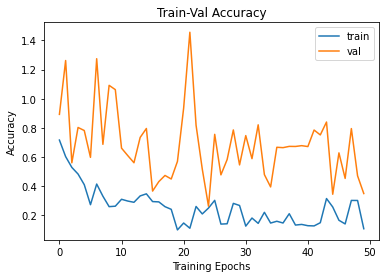

In [333]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
x = np.arange(0,len(loss_hist['train'])) 
y1 = loss_hist['train']
y2 = loss_hist['val']
plt.plot(x,y1,label="train")
plt.plot(x,y2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [334]:
from bokeh.plotting import figure, show

# prepare some data
x = np.arange(0,len(metric_hist['train'])) 
y1 = metric_hist['train']
y2 = metric_hist['val']

# create a new plot with a title and axis labels
p = figure(title="Accuracy of train and val", x_axis_label="x", y_axis_label="y",plot_width=1000, plot_height=500,align="center")
p.title.align = "center"
# add a line renderer with legend and line thickness
p.line(x, y1, legend_label="Train", line_width=2)
p.line(x, y2, legend_label="val", line_color="red", line_width=2)
output_notebook()
# show the results
show(p)

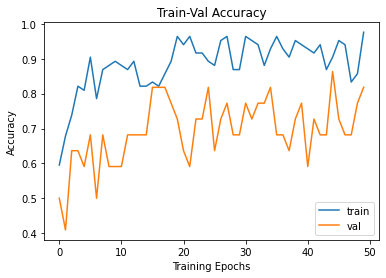

In [336]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
x = np.arange(0,len(metric_hist['train'])) 
y1 = metric_hist['train']
y2 = metric_hist['val']
plt.plot(x,y1,label="train")
plt.plot(x,y2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

test set evaluation
 Accuracy: 0.8182


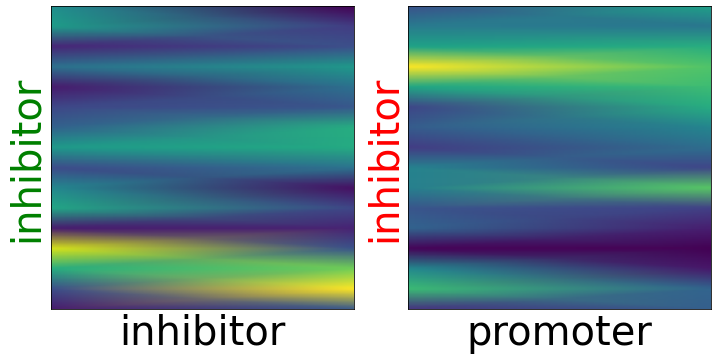

In [306]:
train, pred = show_preds(model,val_dl,show_images,loss_func,class_names)

In [328]:
def print_activation_maps(model, test_loader,loss_func,class_names):
  count=0
  for img,labels in test_loader:
    img = img
    labels = labels
    if(count==4):
      break
    count+=1

  model.eval()
  y_pred = model(change_device(img))
  preds = torch.round(torch.sigmoid(y_pred))
  l = 1
  for r in range(0,4):
    print(f' Actual class: {class_names[int(labels[r].cpu())]} predicted class : {class_names[int(preds[r].cpu())]}')
    plt.figure(figsize=(20, 20))
    plt.subplot(6, 3, l , xticks=[], yticks=[])
    l = l+1
    

    image = np.asarray(img[r]).transpose(1,2,0)
    image = np.clip(image, 0., 1.)
    image_gray = rgb2gray(image)
    plt.imshow(image)

    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(change_device(img)).cpu().detach()
    for i in range(activations.shape[1]):
      activations[:, i, :, :] *= pooled_gradients[i].cpu()
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.subplot(6, 3, l, xticks=[], yticks=[])
    plt.imshow(heatmap[r].squeeze())

    l = l+1
  
    heatmaps = cv2.resize(heatmap[r].numpy(), (image.shape[1], image.shape[0]))
    heatmaps = np.uint8(255 * heatmaps)
    superimposed_img = heatmaps*image_gray
  
    plt.subplot(6, 3, l, xticks=[], yticks=[])
    plt.imshow(superimposed_img)
    plt.show()
    l = l+1

In [329]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

 Actual class: promoter predicted class : promoter


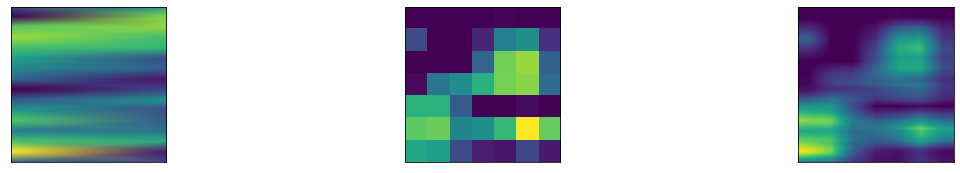

 Actual class: inhibitor predicted class : inhibitor


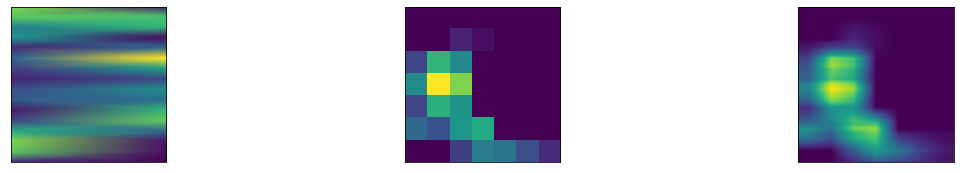

 Actual class: inhibitor predicted class : inhibitor


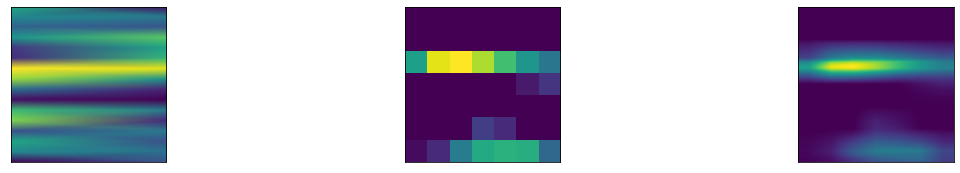

 Actual class: inhibitor predicted class : inhibitor


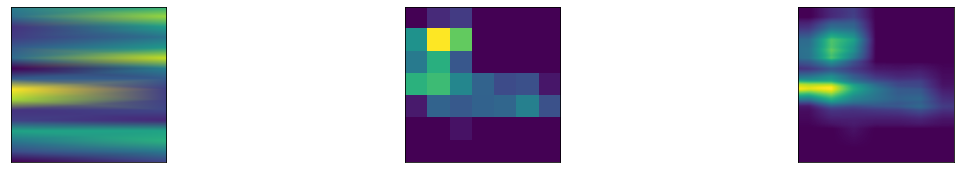

In [330]:
import cv2
print_activation_maps(model, val_dl,loss_func,class_names)

In [331]:
!jupyter nbconvert --to html promoter_classification_using_densenet.ipynb

[NbConvertApp] Converting notebook promoter_classification_using_densenet.ipynb to html
[NbConvertApp] Writing 1640231 bytes to promoter_classification_using_densenet.html


In [332]:
ls

gbbct103.seq                                  promoters_cleaned.gsheet
H3.csv                                        promoters.csv
logs/                                         promoter_spect/
promoter_classification_using_densenet.html   promoter_with_spectogram.csv
promoter_classification_using_densenet.ipynb  runs/
promoters_cleaned.csv                         test.png
